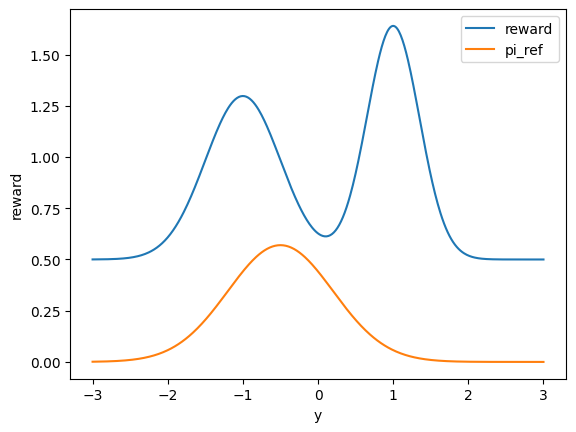

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

def reward_function(y, offset=0.5):
    mean, std_dev = -1, 0.5
    component_1 = (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )
    mean, std_dev = 1, 0.35
    component_2 = (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )
    return component_1 + component_2 + offset

def policy(y):
    mean, std_dev = pi_ref_mu, pi_ref_std
    return (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )

n_sample_plot = 500
pi_ref_mu = -0.5
pi_ref_std = 0.7
y_plot = np.linspace(-3, 3, n_sample_plot)
r_plot = reward_function(y_plot)
pi_plot = policy(y_plot)

plt.plot(y_plot, r_plot, label="reward")
plt.plot(y_plot, pi_plot, label="pi_ref")
plt.xlabel("y")
plt.ylabel("reward")
plt.legend()

Text(0.5, 0, "y'")

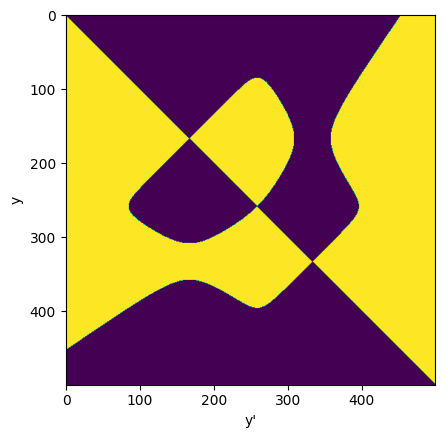

In [2]:
preference_landscape = np.zeros((n_sample_plot, n_sample_plot))
for i in range(n_sample_plot):
    for j in range(n_sample_plot):
        z = reward_function(y_plot[i]) > reward_function(y_plot[j])
        preference_landscape[i, j] = z

plt.imshow(preference_landscape)
plt.ylabel("y")
plt.xlabel("y'")

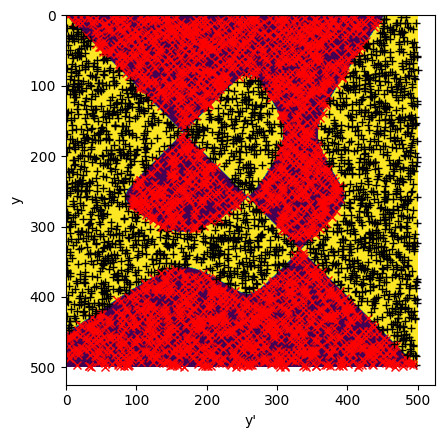

In [3]:
num_samples = 5000
# y_pairs = np.random.normal(pi_ref_mu, pi_ref_std, (num_samples, 2))
y_pairs = np.random.uniform(-3, 3, (5000, 2))
z_pairs = reward_function(y_pairs[:, 0]) > reward_function(y_pairs[:, 1])
map_coord = lambda x: (x + 3) / 6 * n_sample_plot
plt.imshow(preference_landscape)
plt.ylabel("y")
plt.xlabel("y'")
for i, (y, yp) in enumerate(y_pairs):
    if z_pairs[i]:
        label = "+"
        color = "black"
    else:
        label = "x"
        color = "red"
    plt.plot(map_coord(yp), map_coord(y), label, color=color)

In [4]:
from ellm.rm import model as backbone
import torch
from torch import optim
from ml_collections import ConfigDict

model_cls = getattr(backbone, "EnnTSInfoMax")
model_cfg = ConfigDict(
    {
        "enn_max_try": 1,
        "num_ensemble": 1,
        "encoding_dim": 1,
        "rm_hidden_dim": 128,
        "rm_act_fn": "relu",
        "rm_lr": 1e-3,
        "enn_lambda": 0,
        "exp_allow_second_best": False,
        "rm_sgd_steps": 1,
    }
)
model = model_cls(model_cfg)

chosen = 1 - z_pairs
rejected = 1 - chosen
chosen_features = torch.from_numpy(y_pairs[np.arange(num_samples), chosen]).view(-1, 1)
rejected_features = torch.from_numpy(y_pairs[np.arange(num_samples), rejected]).view(-1, 1)
pair_features = torch.stack([chosen_features, rejected_features], dim=1).float()

from ellm.types import RewardData
from ellm.utils.buffer import UniformBuffer

batch = RewardData(
    pair_features=pair_features,
    loss_masks=torch.ones(len(pair_features)),
)
buffer = UniformBuffer(5000)
buffer.extend(batch)
buffer.total_num_queries = 16
model.train_bs = 5000

In [5]:
for _ in range(500):
    if _ % 10 == 0:
        print(_, model.learn(buffer))

0 {'train/rm/loss_rew': tensor(0.6931), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(0.0515), 'train/rm/rejected_rewards': tensor(0.0513), 'train/rm/lambda': 0.0}
10 {'train/rm/loss_rew': tensor(0.6909), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(0.0464), 'train/rm/rejected_rewards': tensor(0.0418), 'train/rm/lambda': 0.0}
20 {'train/rm/loss_rew': tensor(0.6890), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(0.0416), 'train/rm/rejected_rewards': tensor(0.0332), 'train/rm/lambda': 0.0}
30 {'train/rm/loss_rew': tensor(0.6869), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(0.0373), 'train/rm/rejected_rewards': tensor(0.0247), 'train/rm/lambda': 0.0}
40 {'train/rm/loss_rew': tensor(0.6847), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(0.0333), 'train/rm/rejected_rewards': tensor(0.0162), 'train/rm/lambda': 0.0}
50 {'train/rm/loss_rew': tensor(0.6822), 'train/rm/loss_reg': tensor(0.

In [110]:
# test_samples = map_coord(np.random.normal(pi_ref_mu, pi_ref_std, (50, 50, 1)))
# test_samples = np.random.uniform(-3, 3, (50, 50, 1))
test_samples = np.random.uniform(-3, 3, (50, 50, 1))

test_input = torch.from_numpy(test_samples).float()

best = model.get_best_action(test_input)
test_output = test_input[torch.arange(50), best]

(array([244., 238., 268., 248., 265., 236., 212., 269., 253., 267.]),
 array([-2.99912143e+00, -2.39974833e+00, -1.80037534e+00, -1.20100236e+00,
        -6.01629317e-01, -2.25627422e-03,  5.97116768e-01,  1.19648981e+00,
         1.79586279e+00,  2.39523578e+00,  2.99460888e+00]),
 <BarContainer object of 10 artists>)

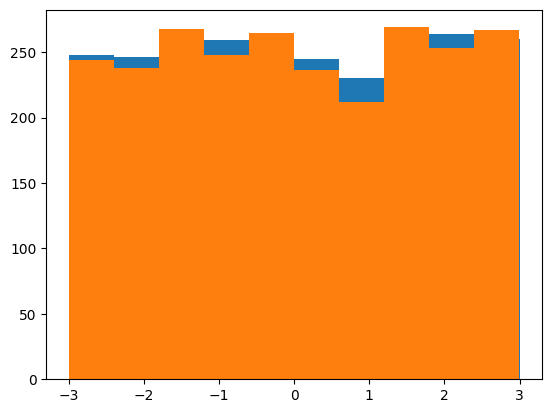

In [111]:
plt.hist(test_samples.reshape(-1))
plt.hist(test_output.reshape(-1))

In [112]:
y_sweep = torch.from_numpy(y_plot).view(1, n_sample_plot, 1).repeat(2, 1, 1).float()
r_pred = model.model(y_sweep).detach()

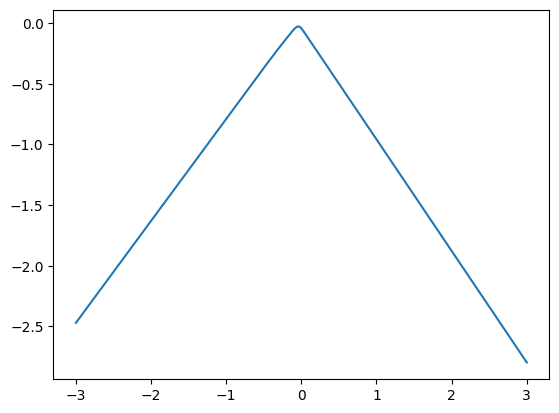

In [113]:
plt.plot(y_plot, r_pred.mean(0).view(-1))